In [1]:
# Setup
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs
from time import clock
import matplotlib.pyplot as plt
import numpy as np
mystr = lambda number : "{:.4f}".format(number)

from copy import copy

In [2]:
# Create two consumers, a perfect foresight one and one with shocks to income

# Standard parameters
IdiosyncDict={
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "PermGroFac" :[1.01],                  # Permanent income growth factor
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.1],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                     # Probability of unemployment while working
    "IncUnemp" : 0.0,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : -500,                  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

# Parameters without uncertainty
PFDict = copy(IdiosyncDict)
PFDict["PermShkStd"] = [0]
PFDict["TranShkStd"] = [0]

In [3]:
# Solve consumers
IndShockConsumer = IndShockConsumerType(**IdiosyncDict)
IndShockConsumer.cycles = 0 # Make this type have an infinite horizon
IndShockConsumer.solve()

PFConsumer = IndShockConsumerType(**PFDict)
PFConsumer.cycles = 0
PFConsumer.solve()

C:\Users\Mateo\Anaconda3\lib\site-packages\HARK\utilities.py:160: RuntimeWarning: divide by zero encountered in power
  return( c**-gam )


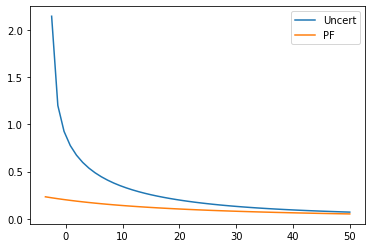

In [4]:
# Figure 1
m_max = 50
m_grid = np.linspace(IndShockConsumer.solution[0].mNrmMin, m_max, 50)

plt.figure()
plt.plot(m_grid, IndShockConsumer.solution[0].vPfunc(m_grid), label = 'Uncert')
plt.plot(m_grid, PFConsumer.solution[0].vPfunc(m_grid), label = 'PF')
plt.legend()

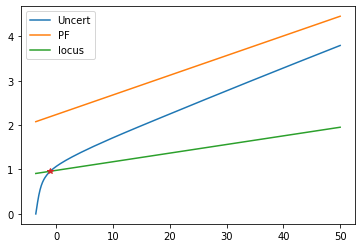

In [5]:
# Figure 2

# Define a function for the delta(m)=0 locus
m0_locus = lambda m: m - (m-1)/(IdiosyncDict["Rfree"]/IdiosyncDict["PermGroFac"][0])

# Define grid of market resources
m_max = 50
m_grid = np.linspace(IndShockConsumer.solution[0].mNrmMin, m_max, 500)

plt.figure()
plt.plot(m_grid, IndShockConsumer.solution[0].cFunc(m_grid), label = 'Uncert')
plt.plot(m_grid, PFConsumer.solution[0].cFunc(m_grid), label = 'PF')
plt.plot(m_grid, m0_locus(m_grid), label = 'locus')
plt.plot(IndShockConsumer.solution[0].mNrmSS,
         IndShockConsumer.solution[0].cFunc(IndShockConsumer.solution[0].mNrmSS),'*')
plt.legend()